In [1]:
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import warnings
logger = tf.get_logger()

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [58]:
logging.basicConfig(encoding='utf-8', level=logging.INFO,
                    force = True)

In [48]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [49]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [50]:
# G = build_test_graph1()
# G = nx.complete_graph(10)
# G = nx.graph_atlas(1000)
# G = nx.gnp_random_graph(20, 0.075, seed = 3)

# nx.draw(G)

In [51]:
def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c))
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_omega(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
    logging.info("Max degree = {}".format(max_degree))
    return np.array([1 - G.degree(i)/max_degree + random.random()/10000 for i in range(n)])

def build_network(G):
    logging.info("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    omega = build_omega(G)
    logging.info("Initial omega = {}".format(omega))
    return (W,b,w, omega, C)


In [52]:
def get_result_nodes(omega, alpha = 0.5):
    return set(np.argwhere(omega.numpy() > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, omega):
    result_nodes = get_result_nodes(omega) 
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False 
        

            
def train_network(G, max_epochs = 100):
    (W,b,w, omega, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    omega = tf.Variable(omega,
                        trainable=True,
                        dtype = 'float32', 
                        constraint = lambda a: tf.clip_by_value(a,0,1))
#     omega = tf.Variable(omega, dtype = 'float32')

    def network():
#         h = tf.sigmoid(omega) # To make variable be from 0 to 1
        h = tf.math.multiply(e_n,omega)
        h = tf.linalg.matvec(W_t,h)
        h = tf.add(h,b)
        h = tf.nn.relu(h)
        h = tf.tensordot(w_t,h, 1)
        return h

    def loss():
        h = network()
        return (h-h_d)*(h-h_d)
    
    e_n = tf.ones((n))

    h_d = -n*n/2 # Desired result. Is needed for minimization the mean
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    
    epoch = 0
    while not_connected_nodes_exist_in_G(G, omega) and epoch < max_epochs:
        logging.info("Epoch = {}".format(epoch))
        optimizer.minimize(loss, var_list=[omega])
        logging.debug("Omega = {}".format(omega))
        previous_error = loss()
        logging.info("Error = {}".format(previous_error))
        epoch+=1
            
    logging.info("Total epochs = {}".format(epoch))
    return omega


In [107]:
def graphSets(graph):
      
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [108]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [109]:
def calculate_DNN_result(G, omega, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(omega)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [110]:
def compareResults(G, max_epochs = 100, draw_graph = True):
    calculate_recursive_broot_force_result(G)
    omega = train_network(G, max_epochs)
    calculate_determenistic_result(G, draw_graph)
    calculate_DNN_result(G, omega, draw_graph=draw_graph)

{0: [1, 2, 6], 1: [0, 3, 7], 2: [0, 3, 4], 3: [1, 2, 5], 4: [2, 5, 6], 5: [3, 4, 7], 6: [0, 4, 7], 7: [1, 5, 6]}
Recursive approach
[0, 3, 4, 7]
Length = 4


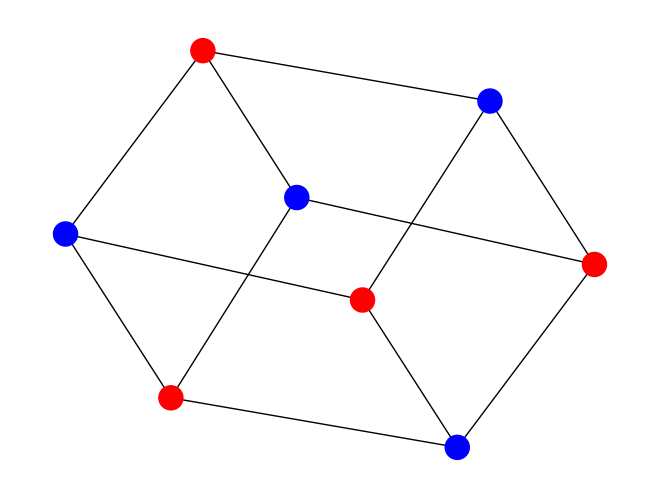

INFO:root:Build network on graph G:Graph with 8 nodes and 12 edges.
INFO:root:Max degree = 3
INFO:root:Initial omega = [7.78765270e-06 7.93903545e-05 1.24919916e-05 4.46290359e-05
 5.58804957e-05 1.67071291e-05 4.98518499e-05 3.18790545e-05]
INFO:root:Epoch = 0
INFO:root:Error = 1024.0
INFO:root:Epoch = 1
INFO:root:Error = 1024.0
INFO:root:Epoch = 2
INFO:root:Error = 1024.0
INFO:root:Epoch = 3
INFO:root:Error = 1024.0
INFO:root:Epoch = 4
INFO:root:Error = 1024.0
INFO:root:Epoch = 5
INFO:root:Error = 1024.0
INFO:root:Epoch = 6
INFO:root:Error = 1024.0
INFO:root:Epoch = 7
INFO:root:Error = 1024.0
INFO:root:Epoch = 8
INFO:root:Error = 1024.0
INFO:root:Epoch = 9
INFO:root:Error = 1024.0
INFO:root:Epoch = 10
INFO:root:Error = 1024.0
INFO:root:Epoch = 11
INFO:root:Error = 1024.0
INFO:root:Epoch = 12
INFO:root:Error = 1024.0
INFO:root:Epoch = 13
INFO:root:Error = 1024.0
INFO:root:Epoch = 14
INFO:root:Error = 1024.0
INFO:root:Epoch = 15
INFO:root:Error = 1024.0
INFO:root:Epoch = 16
INFO:root:E

Deterministic built-in approach
[7, 4, 3, 0]
Length = 4


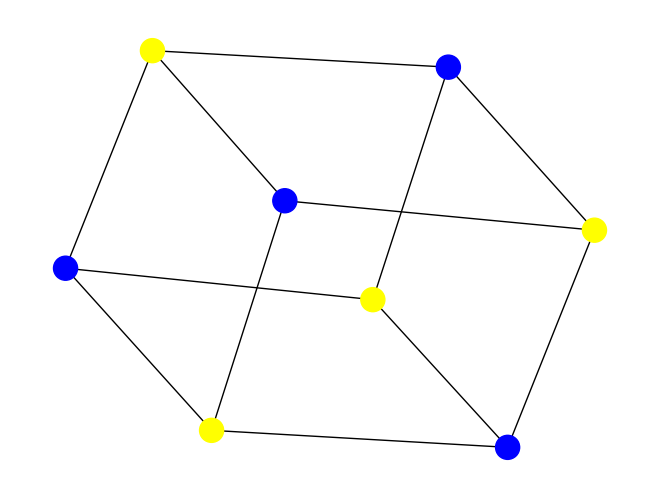

DNN approach
set()
Length = 0


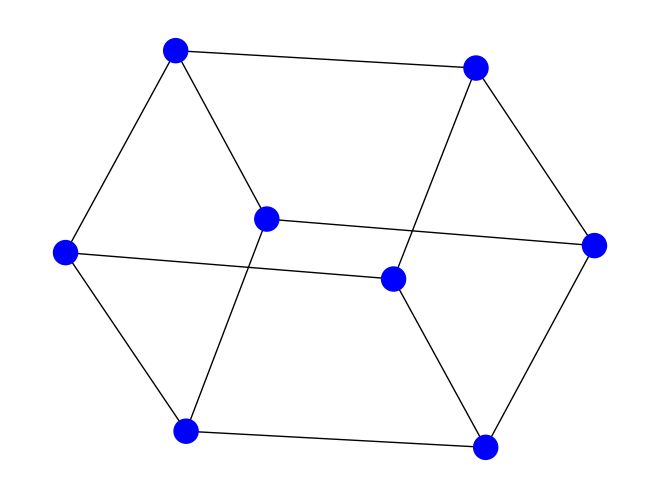

In [105]:
compareResults(build_test_graph1(), 50)

{0: [1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [0, 2, 3, 4, 5, 6, 7, 8, 9], 2: [0, 1, 3, 4, 5, 6, 7, 8, 9], 3: [0, 1, 2, 4, 5, 6, 7, 8, 9], 4: [0, 1, 2, 3, 5, 6, 7, 8, 9], 5: [0, 1, 2, 3, 4, 6, 7, 8, 9], 6: [0, 1, 2, 3, 4, 5, 7, 8, 9], 7: [0, 1, 2, 3, 4, 5, 6, 8, 9], 8: [0, 1, 2, 3, 4, 5, 6, 7, 9], 9: [0, 1, 2, 3, 4, 5, 6, 7, 8]}
Recursive approach
[0]
Length = 1


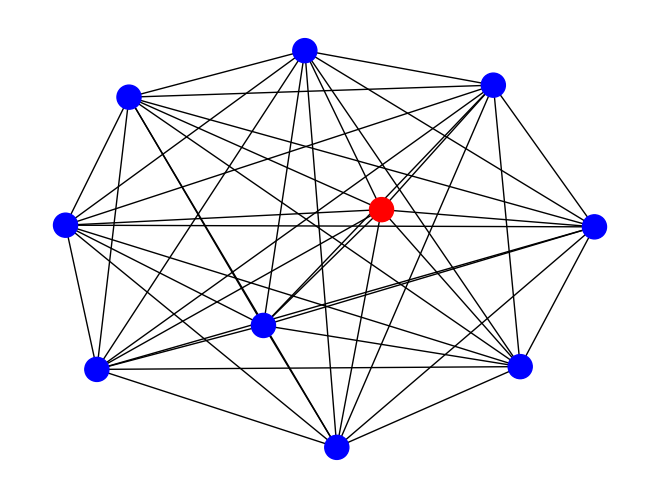

INFO:root:Build network on graph G:Graph with 10 nodes and 45 edges.
INFO:root:Max degree = 9
INFO:root:Initial omega = [2.82262035e-05 3.75257605e-05 1.35875027e-05 9.88557361e-05
 6.26174024e-05 1.92732627e-05 3.19521909e-05 7.18418607e-07
 3.12294023e-05 6.80168185e-06]
INFO:root:Epoch = 0
INFO:root:Error = 2500.0
INFO:root:Epoch = 1
INFO:root:Error = 2500.0
INFO:root:Epoch = 2
INFO:root:Error = 2500.0
INFO:root:Epoch = 3
INFO:root:Error = 2500.0
INFO:root:Epoch = 4
INFO:root:Error = 2500.0
INFO:root:Epoch = 5
INFO:root:Error = 2500.0
INFO:root:Epoch = 6
INFO:root:Error = 2500.0
INFO:root:Epoch = 7
INFO:root:Error = 2500.0
INFO:root:Epoch = 8
INFO:root:Error = 2500.0
INFO:root:Epoch = 9
INFO:root:Error = 2500.0
INFO:root:Epoch = 10
INFO:root:Error = 2500.0
INFO:root:Epoch = 11
INFO:root:Error = 2500.0
INFO:root:Epoch = 12
INFO:root:Error = 2500.0
INFO:root:Epoch = 13
INFO:root:Error = 2500.0
INFO:root:Epoch = 14
INFO:root:Error = 2500.0
INFO:root:Epoch = 15
INFO:root:Error = 2500.0


Deterministic built-in approach
[1]
Length = 1
DNN approach
set()
Length = 0


In [106]:
compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

Recursive approach
[0, 2, 4]
Length = 3


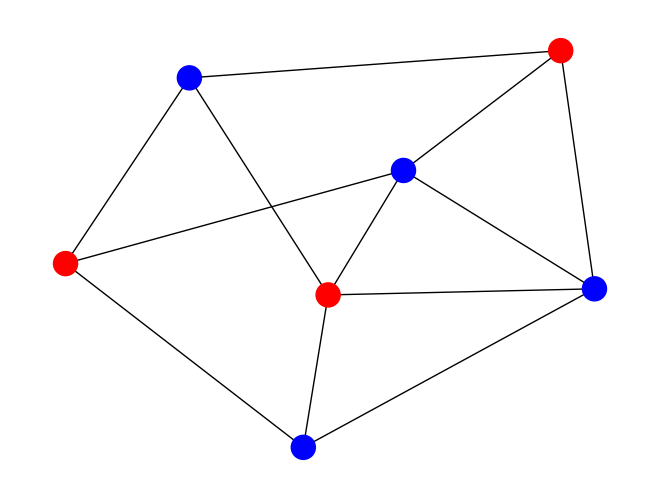

INFO:root:Build network on graph G:Graph named 'G1000' with 7 nodes and 12 edges.
INFO:root:Max degree = 4
INFO:root:Initial omega = [2.50083858e-01 2.50086007e-01 2.50002886e-01 2.50077901e-01
 3.17149237e-05 2.46757791e-05 2.28033744e-05]
INFO:root:Epoch = 0
INFO:root:Error = 600.25
INFO:root:Epoch = 1
INFO:root:Error = 600.25
INFO:root:Epoch = 2
INFO:root:Error = 600.25
INFO:root:Epoch = 3
INFO:root:Error = 600.25
INFO:root:Epoch = 4
INFO:root:Error = 600.25
INFO:root:Epoch = 5
INFO:root:Error = 600.25
INFO:root:Epoch = 6
INFO:root:Error = 600.25
INFO:root:Epoch = 7
INFO:root:Error = 600.25
INFO:root:Epoch = 8
INFO:root:Error = 600.25
INFO:root:Epoch = 9
INFO:root:Error = 600.25
INFO:root:Epoch = 10
INFO:root:Error = 600.25
INFO:root:Epoch = 11
INFO:root:Error = 600.25
INFO:root:Epoch = 12
INFO:root:Error = 600.25
INFO:root:Epoch = 13
INFO:root:Error = 600.25
INFO:root:Epoch = 14
INFO:root:Error = 600.25
INFO:root:Epoch = 15
INFO:root:Error = 600.25
INFO:root:Epoch = 16
INFO:root:Er

Deterministic built-in approach
[4, 2, 0]
Length = 3
DNN approach
set()
Length = 0


In [111]:
compareResults(nx.graph_atlas(1000),draw_graph=False)

Recursive approach
[0, 1, 2, 3, 5, 6, 8, 9, 10, 12, 14, 18]
Length = 12


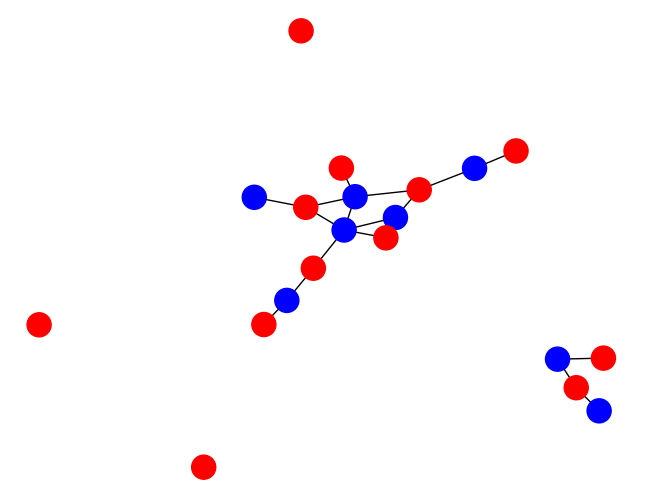

INFO:root:Build network on graph G:Graph with 20 nodes and 18 edges.
INFO:root:Max degree = 5
INFO:root:Initial omega = [8.00058587e-01 8.00008149e-01 1.00009616e+00 6.00023763e-01
 6.00033897e-01 1.00003655e+00 4.00048647e-01 4.00071221e-01
 8.00069821e-01 1.00008814e+00 6.00056070e-01 2.00035387e-01
 4.00065084e-01 6.00083399e-01 6.00051816e-01 2.13772003e-06
 8.00043633e-01 8.00040479e-01 8.00010877e-01 6.00089701e-01]
INFO:root:Epoch = 0
INFO:root:Error = 29930.06640625
INFO:root:Epoch = 1
INFO:root:Error = 27760.716796875
INFO:root:Epoch = 2
INFO:root:Error = 28362.6328125
INFO:root:Epoch = 3
INFO:root:Error = 28757.708984375
INFO:root:Epoch = 4
INFO:root:Error = 27547.181640625
INFO:root:Epoch = 5
INFO:root:Error = 25052.146484375
INFO:root:Epoch = 6
INFO:root:Error = 23529.169921875
INFO:root:Epoch = 7
INFO:root:Error = 22075.681640625
INFO:root:Epoch = 8
INFO:root:Error = 20496.42578125
INFO:root:Epoch = 9
INFO:root:Error = 19698.103515625
INFO:root:Epoch = 10
INFO:root:Error =

INFO:root:Error = 16384.0
INFO:root:Epoch = 161
INFO:root:Error = 16384.0
INFO:root:Epoch = 162
INFO:root:Error = 16384.0
INFO:root:Epoch = 163
INFO:root:Error = 16384.0
INFO:root:Epoch = 164
INFO:root:Error = 16384.0
INFO:root:Epoch = 165
INFO:root:Error = 16384.0
INFO:root:Epoch = 166
INFO:root:Error = 16384.0
INFO:root:Epoch = 167
INFO:root:Error = 16384.0
INFO:root:Epoch = 168
INFO:root:Error = 16384.0
INFO:root:Epoch = 169
INFO:root:Error = 16384.0
INFO:root:Epoch = 170
INFO:root:Error = 16384.0
INFO:root:Epoch = 171
INFO:root:Error = 16384.0
INFO:root:Epoch = 172
INFO:root:Error = 16384.0
INFO:root:Epoch = 173
INFO:root:Error = 16384.0
INFO:root:Epoch = 174
INFO:root:Error = 16384.0
INFO:root:Epoch = 175
INFO:root:Error = 16384.0
INFO:root:Epoch = 176
INFO:root:Error = 16384.0
INFO:root:Epoch = 177
INFO:root:Error = 16384.0
INFO:root:Epoch = 178
INFO:root:Error = 16384.0
INFO:root:Epoch = 179
INFO:root:Error = 16384.0
INFO:root:Epoch = 180
INFO:root:Error = 16384.0
INFO:root:Epoc

Deterministic built-in approach
[3, 7, 13, 19, 0, 12, 2, 5, 9, 1]
Length = 10


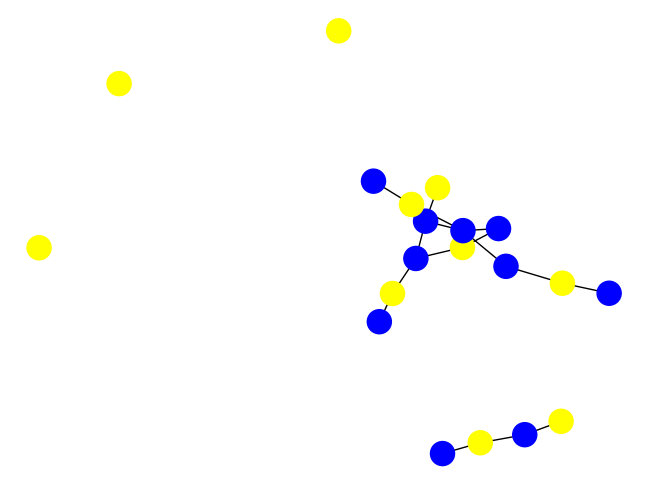

DNN approach
{0, 1, 2, 5, 6, 8, 9, 10, 14, 16, 17, 18}
Length = 12


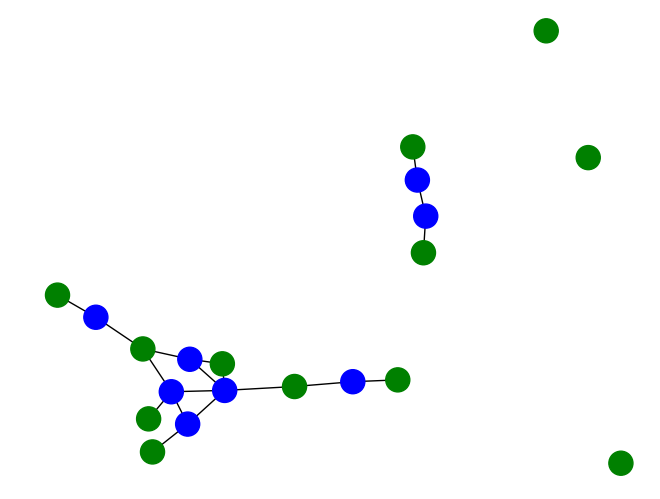

In [112]:
compareResults(nx.gnp_random_graph(20, 0.075), 200) #Expected result around 12-14

Recursive approach
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 19, 21, 24, 27, 28, 29]
Length = 21


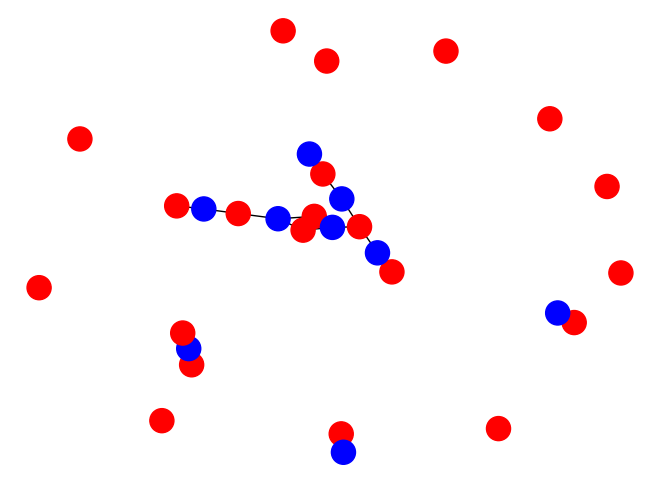

INFO:root:Build network on graph G:Graph with 30 nodes and 17 edges.
INFO:root:Max degree = 3
INFO:root:Initial omega = [1.00000712e+00 1.00006743e+00 6.66757755e-01 3.33338794e-01
 1.00002378e+00 1.00005968e+00 1.00003785e+00 6.66685918e-01
 4.68403478e-05 3.33385575e-01 1.00008500e+00 3.33352068e-01
 3.33385209e-01 6.66758751e-01 6.66727505e-01 3.33381009e-01
 6.66718950e-01 3.33414739e-01 3.33403402e-01 1.00007665e+00
 6.54866311e-05 6.66739642e-01 1.40476399e-05 6.66714021e-01
 1.00006103e+00 6.66707952e-01 6.66735212e-01 3.33415112e-01
 1.00001982e+00 1.00009154e+00]
INFO:root:Epoch = 0
INFO:root:Error = 103805.15625
INFO:root:Epoch = 1
INFO:root:Error = 92809.515625
INFO:root:Epoch = 2
INFO:root:Error = 78829.6484375
INFO:root:Epoch = 3
INFO:root:Error = 83467.984375
INFO:root:Epoch = 4
INFO:root:Error = 82947.640625
INFO:root:Epoch = 5
INFO:root:Error = 76907.21875
INFO:root:Epoch = 6
INFO:root:Error = 69718.71875
INFO:root:Epoch = 7
INFO:root:Error = 67177.1953125
INFO:root:Epo

INFO:root:Error = 53706.25390625
INFO:root:Epoch = 144
INFO:root:Error = 53667.171875
INFO:root:Epoch = 145
INFO:root:Error = 53683.296875
INFO:root:Epoch = 146
INFO:root:Error = 53603.15234375
INFO:root:Epoch = 147
INFO:root:Error = 53964.3046875
INFO:root:Epoch = 148
INFO:root:Error = 53784.8984375
INFO:root:Epoch = 149
INFO:root:Error = 53802.60546875
INFO:root:Epoch = 150
INFO:root:Error = 53971.4375
INFO:root:Epoch = 151
INFO:root:Error = 54028.63671875
INFO:root:Epoch = 152
INFO:root:Error = 53984.80078125
INFO:root:Epoch = 153
INFO:root:Error = 53849.796875
INFO:root:Epoch = 154
INFO:root:Error = 53632.8515625
INFO:root:Epoch = 155
INFO:root:Error = 54187.55078125
INFO:root:Epoch = 156
INFO:root:Error = 54268.609375
INFO:root:Epoch = 157
INFO:root:Error = 53803.35546875
INFO:root:Epoch = 158
INFO:root:Error = 53902.2421875
INFO:root:Epoch = 159
INFO:root:Error = 54168.1640625
INFO:root:Epoch = 160
INFO:root:Error = 54313.03515625
INFO:root:Epoch = 161
INFO:root:Error = 54348.019

INFO:root:Epoch = 295
INFO:root:Error = 53786.3203125
INFO:root:Epoch = 296
INFO:root:Error = 53870.89453125
INFO:root:Epoch = 297
INFO:root:Error = 53851.140625
INFO:root:Epoch = 298
INFO:root:Error = 53737.7578125
INFO:root:Epoch = 299
INFO:root:Error = 53716.265625
INFO:root:Epoch = 300
INFO:root:Error = 53599.68359375
INFO:root:Epoch = 301
INFO:root:Error = 53859.12109375
INFO:root:Epoch = 302
INFO:root:Error = 54007.16015625
INFO:root:Epoch = 303
INFO:root:Error = 54044.86328125
INFO:root:Epoch = 304
INFO:root:Error = 53982.5703125
INFO:root:Epoch = 305
INFO:root:Error = 53830.52734375
INFO:root:Epoch = 306
INFO:root:Error = 53597.87890625
INFO:root:Epoch = 307
INFO:root:Error = 54305.640625
INFO:root:Epoch = 308
INFO:root:Error = 54415.0859375
INFO:root:Epoch = 309
INFO:root:Error = 53969.2109375
INFO:root:Epoch = 310
INFO:root:Error = 53827.796875
INFO:root:Epoch = 311
INFO:root:Error = 54088.25390625
INFO:root:Epoch = 312
INFO:root:Error = 54227.2890625
INFO:root:Epoch = 313
IN

INFO:root:Error = 53911.24609375
INFO:root:Epoch = 447
INFO:root:Error = 53745.1640625
INFO:root:Epoch = 448
INFO:root:Error = 53811.6953125
INFO:root:Epoch = 449
INFO:root:Error = 53794.72265625
INFO:root:Epoch = 450
INFO:root:Error = 53740.38671875
INFO:root:Epoch = 451
INFO:root:Error = 53855.25
INFO:root:Epoch = 452
INFO:root:Error = 53862.7421875
INFO:root:Epoch = 453
INFO:root:Error = 53773.4609375
INFO:root:Epoch = 454
INFO:root:Error = 53597.1953125
INFO:root:Epoch = 455
INFO:root:Error = 54185.97265625
INFO:root:Epoch = 456
INFO:root:Error = 54186.5546875
INFO:root:Epoch = 457
INFO:root:Error = 53644.7109375
INFO:root:Epoch = 458
INFO:root:Error = 54001.48828125
INFO:root:Epoch = 459
INFO:root:Error = 54295.21484375
INFO:root:Epoch = 460
INFO:root:Error = 54463.58984375
INFO:root:Epoch = 461
INFO:root:Error = 54518.5390625
INFO:root:Epoch = 462
INFO:root:Error = 54470.85546875
INFO:root:Epoch = 463
INFO:root:Error = 54330.859375
INFO:root:Epoch = 464
INFO:root:Error = 54108.11

INFO:root:Epoch = 598
INFO:root:Error = 53774.2109375
INFO:root:Epoch = 599
INFO:root:Error = 53602.63671875
INFO:root:Epoch = 600
INFO:root:Error = 54163.359375
INFO:root:Epoch = 601
INFO:root:Error = 54155.0703125
INFO:root:Epoch = 602
INFO:root:Error = 53604.515625
INFO:root:Epoch = 603
INFO:root:Error = 54022.140625
INFO:root:Epoch = 604
INFO:root:Error = 54318.99609375
INFO:root:Epoch = 605
INFO:root:Error = 54490.06640625
INFO:root:Epoch = 606
INFO:root:Error = 54546.98046875
INFO:root:Epoch = 607
INFO:root:Error = 54501.14453125
INFO:root:Epoch = 608
INFO:root:Error = 54362.61328125
INFO:root:Epoch = 609
INFO:root:Error = 54141.07421875
INFO:root:Epoch = 610
INFO:root:Error = 53845.42578125
INFO:root:Epoch = 611
INFO:root:Error = 53850.19140625
INFO:root:Epoch = 612
INFO:root:Error = 54081.2421875
INFO:root:Epoch = 613
INFO:root:Error = 53745.5390625
INFO:root:Epoch = 614
INFO:root:Error = 53881.7734375
INFO:root:Epoch = 615
INFO:root:Error = 54105.24609375
INFO:root:Epoch = 616

INFO:root:Error = 54380.5234375
INFO:root:Epoch = 750
INFO:root:Error = 54225.28515625
INFO:root:Epoch = 751
INFO:root:Error = 53989.01953125
INFO:root:Epoch = 752
INFO:root:Error = 53680.2421875
INFO:root:Epoch = 753
INFO:root:Error = 54271.90625
INFO:root:Epoch = 754
INFO:root:Error = 54527.2109375
INFO:root:Epoch = 755
INFO:root:Error = 54208.609375
INFO:root:Epoch = 756
INFO:root:Error = 53681.453125
INFO:root:Epoch = 757
INFO:root:Error = 53899.4453125
INFO:root:Epoch = 758
INFO:root:Error = 53999.84375
INFO:root:Epoch = 759
INFO:root:Error = 53994.04296875
INFO:root:Epoch = 760
INFO:root:Error = 53892.16015625
INFO:root:Epoch = 761
INFO:root:Error = 53704.58984375
INFO:root:Epoch = 762
INFO:root:Error = 53954.76171875
INFO:root:Epoch = 763
INFO:root:Error = 53978.171875
INFO:root:Epoch = 764
INFO:root:Error = 53649.09375
INFO:root:Epoch = 765
INFO:root:Error = 53750.75390625
INFO:root:Epoch = 766
INFO:root:Error = 53746.23046875
INFO:root:Epoch = 767
INFO:root:Error = 53646.42187

INFO:root:Epoch = 901
INFO:root:Error = 54056.91015625
INFO:root:Epoch = 902
INFO:root:Error = 53924.61328125
INFO:root:Epoch = 903
INFO:root:Error = 53709.1796875
INFO:root:Epoch = 904
INFO:root:Error = 54002.72265625
INFO:root:Epoch = 905
INFO:root:Error = 54078.859375
INFO:root:Epoch = 906
INFO:root:Error = 53603.9375
INFO:root:Epoch = 907
INFO:root:Error = 53994.35546875
INFO:root:Epoch = 908
INFO:root:Error = 54265.49609375
INFO:root:Epoch = 909
INFO:root:Error = 54413.40625
INFO:root:Epoch = 910
INFO:root:Error = 54449.49609375
INFO:root:Epoch = 911
INFO:root:Error = 54384.62109375
INFO:root:Epoch = 912
INFO:root:Error = 54229.3359375
INFO:root:Epoch = 913
INFO:root:Error = 53992.80078125
INFO:root:Epoch = 914
INFO:root:Error = 53683.94140625
INFO:root:Epoch = 915
INFO:root:Error = 54263.71875
INFO:root:Epoch = 916
INFO:root:Error = 54519.11328125
INFO:root:Epoch = 917
INFO:root:Error = 54200.55078125
INFO:root:Epoch = 918
INFO:root:Error = 53684.88671875
INFO:root:Epoch = 919
IN

Deterministic built-in approach
[16, 24, 1, 27, 12, 5, 0, 13, 10, 7, 29, 21, 6, 28, 3, 26, 11, 19, 4, 2]
Length = 20


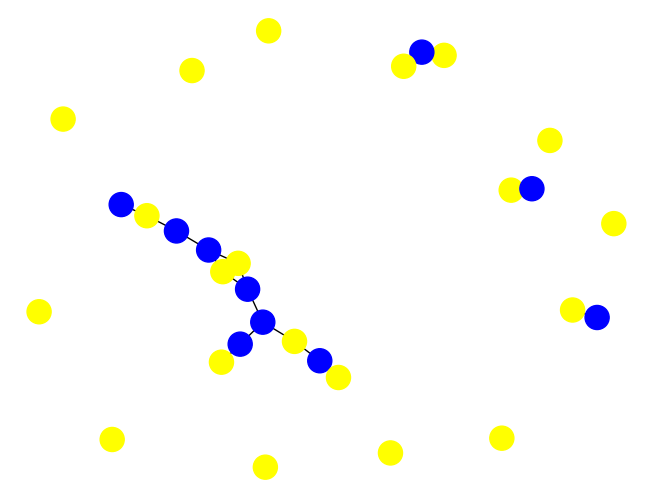

DNN approach
{0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29}
Length = 23


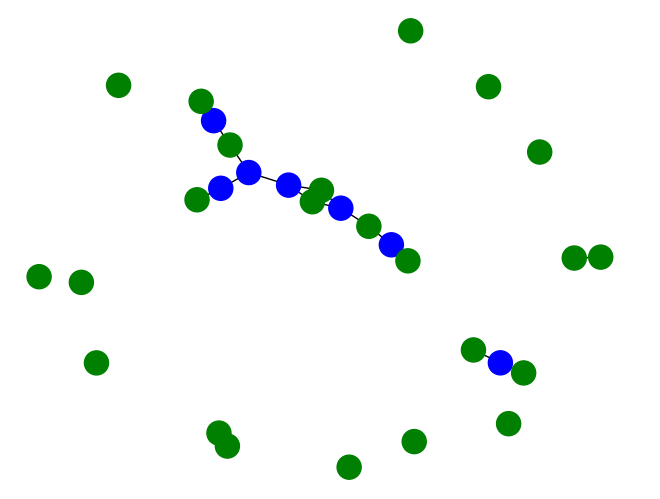

In [114]:
compareResults(nx.gnp_random_graph(50, 0.05), max_epochs = 1000)

In [ ]:
compareResults(nx.gnp_random_graph(1000, 0.1), max_epochs = 100)

In [ ]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [ ]:
wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt') 

In [ ]:
wiki_vote_G

In [ ]:
logging.info(wiki_vote_G)

In [ ]:
# compareResults(wiki_vote_G)
# Not working now. Too much amount of data needed. Need optimization.

In [ ]:
7115*25315170*64/1024/1024/1024/1024